In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce

#For interactive plots 
import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate

In [2]:
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')


inflation_rate_df=get_inflation_rate()
franchise_df=get_franchise_movies(movies_df,inflation_rate_df)


#franchise_data_df = get_franchise_data(franchise_df)


# average years between movies of a franchise
#franchise_data_df['average_years_bt_movies'] = franchise_data_df['franchise_length_years'] / (franchise_data_df['movie_count']-1)



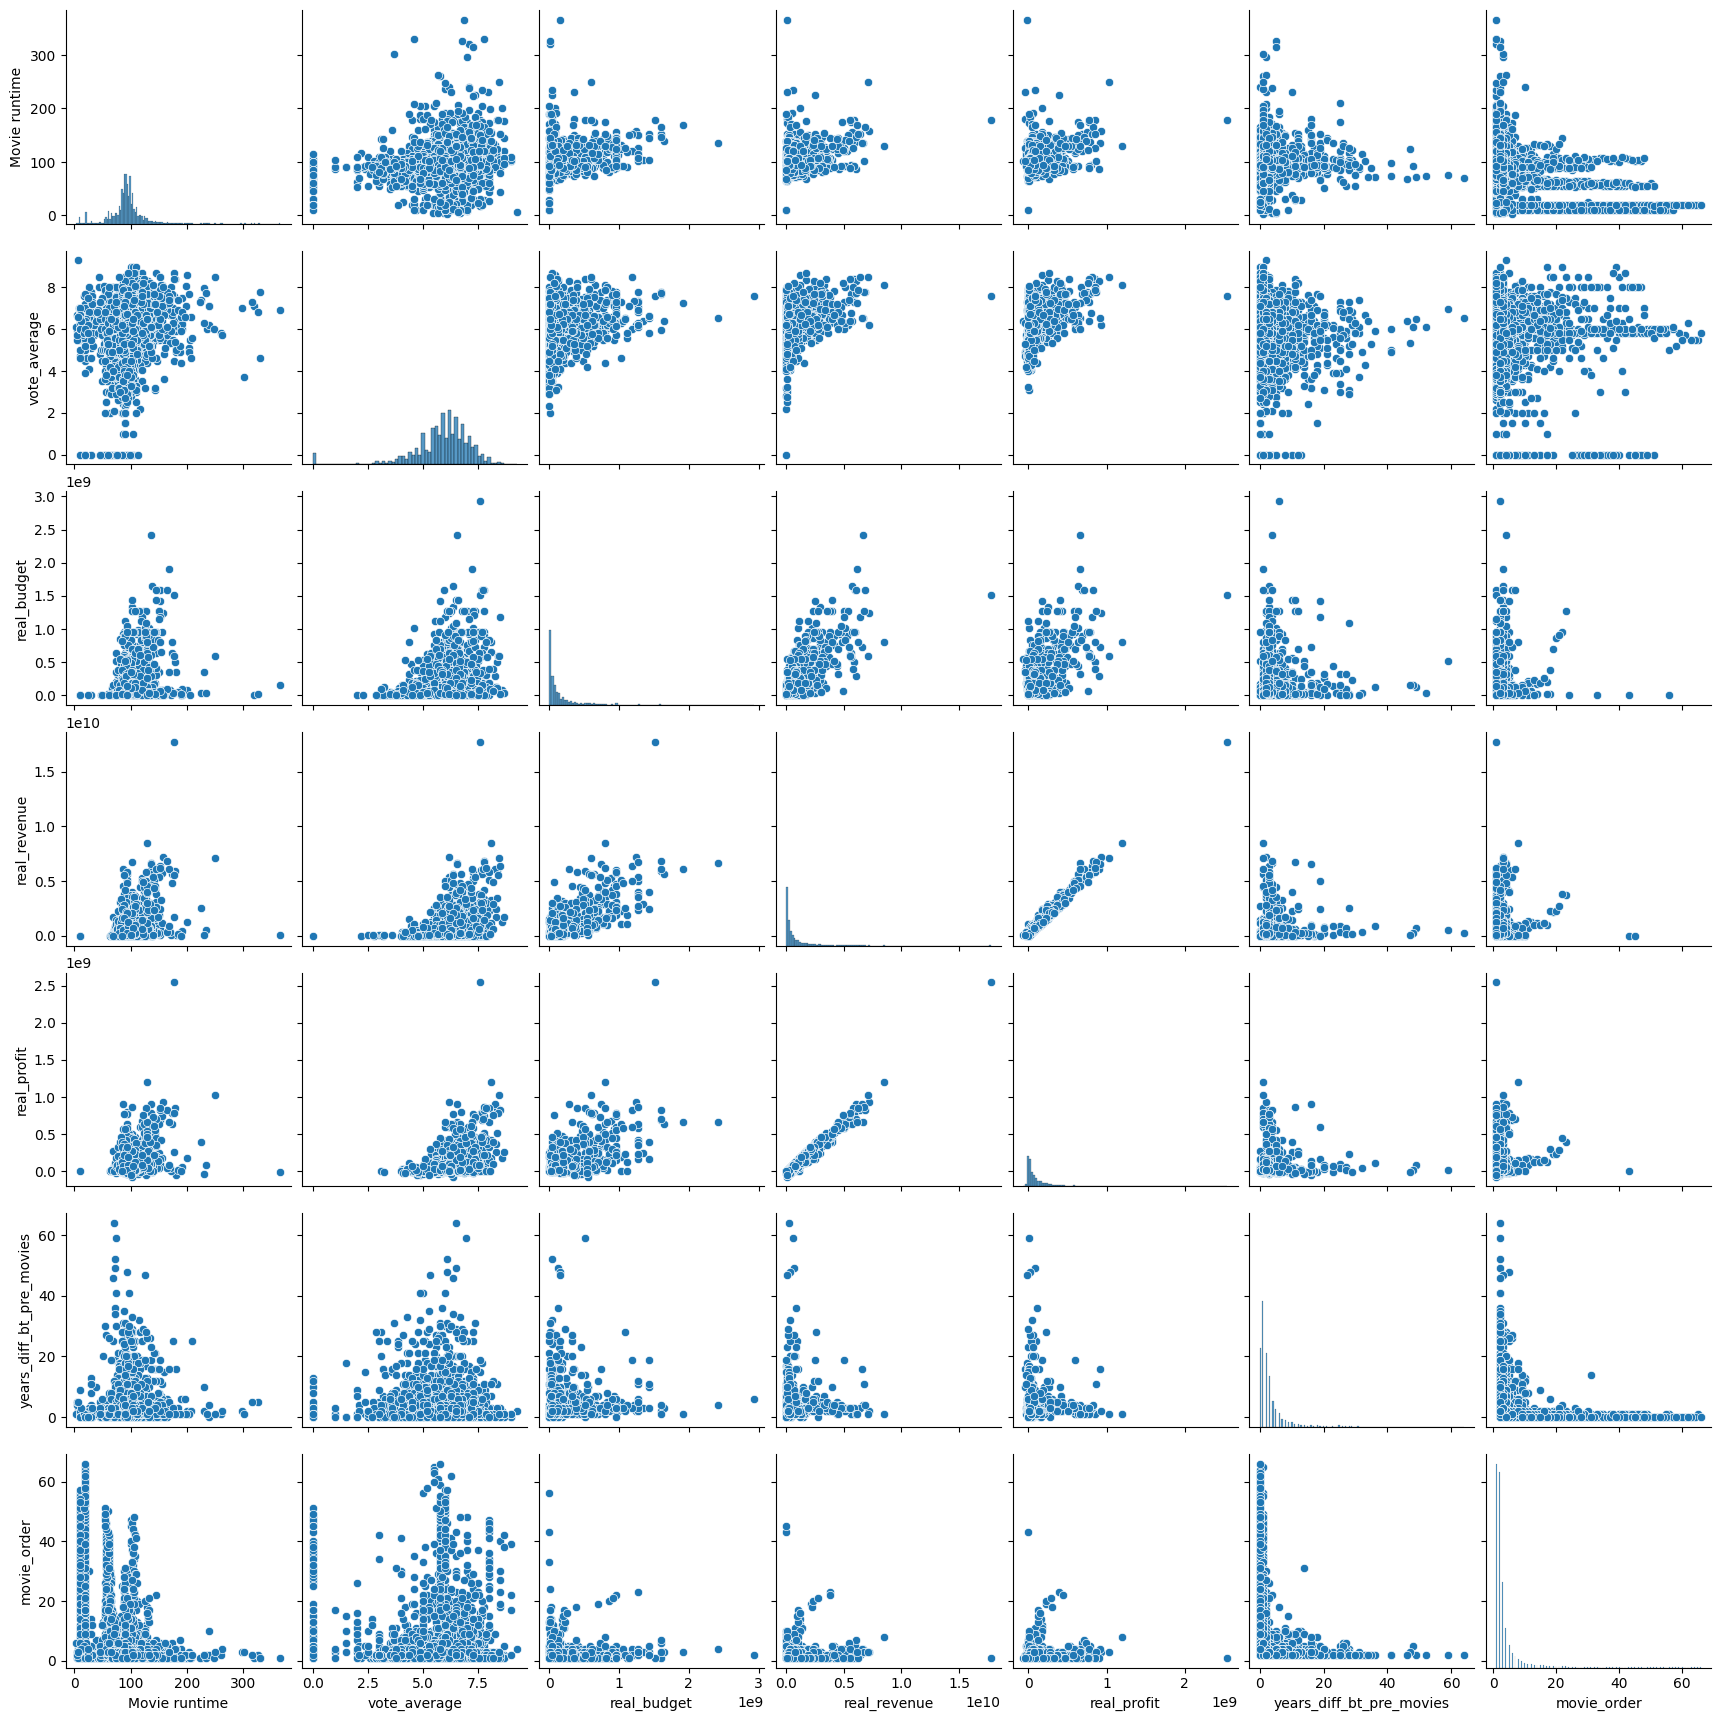

In [5]:
sns.pairplot(franchise_df[['Movie runtime','vote_average','real_budget','real_revenue','real_profit','years_diff_bt_pre_movies','movie_order']])

In [17]:
# analysis of the difference between the first en second movies
fsm_df = franchise_df[(franchise_df['movie_order'] == 1) | (franchise_df['movie_order'] == 2)]
fsm_df = fsm_df[['Movie name','collection_name','movie_order','real_budget','real_revenue','real_profit','years_diff_bt_pre_movies']]
fsm_df.sort_values(by='movie_order',inplace=True)
fsm_df['diff_profit_1_2'] = fsm_df.groupby('collection_name')['real_profit'].diff()
fsm_df['diff_budget_1_2'] = fsm_df.groupby('collection_name')['real_budget'].diff()
fsm_df['diff_revenue_1_2'] = fsm_df.groupby('collection_name')['real_revenue'].diff()
sm_df = fsm_df[fsm_df['movie_order'] == 2]
sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']
sm_df=sm_df[sm_df['diff_profit_1_2'].notna()]


/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_44907/508168286.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']


In [25]:
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

# Define the features and the label
X = sm_df[['real_budget','years_diff_bt_pre_movies','diff_profit_1_2','diff_budget_1_2']]
y = sm_df['profit_over_budget']

# Standardize the features
X_std = StandardScaler().fit_transform(X)

# Add a constant to the features (intercept term)
X_std = sm.add_constant(X_std)

# Fit the regression model
model = sm.OLS(y, X_std).fit()

# Print the summary of the regression model
print(model.summary())

results_table = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.params[1:],
    'P-value': model.pvalues[1:]
})
print(results_table)

                            OLS Regression Results                            
Dep. Variable:     profit_over_budget   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.090
Date:                Mon, 09 Dec 2024   Prob (F-statistic):             0.0166
Time:                        11:37:48   Log-Likelihood:                -415.21
No. Observations:                 251   AIC:                             840.4
Df Residuals:                     246   BIC:                             858.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5874      0.081      7.282      0.0